<center><h1>Chang_Yi_HW6</h1></center>

Name: Yi Chang
<br>
Github Username: Evangeline-Chang
<br>
USC ID: 1959039727

## 1. Tree-Based Methods

Import packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

### (a) Download the APS Failure data

In [4]:
training = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=list(range(0, 20)), na_values='na')
test = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=list(range(0, 20)), na_values='na')

training['class'] = training['class'].apply(lambda x: 1 if x=='pos' else 0)
test['class'] = test['class'].apply(lambda x: 1 if x=='pos' else 0)

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

mean, median, mode

In [5]:
training = training.apply(pd.to_numeric, errors='ignore')
median_values = training.median()
training.fillna(median_values, inplace=True)

test = test.apply(pd.to_numeric, errors='ignore')
test.fillna(median_values, inplace=True)

#### (ii) Calculate the coefficient of variation

In [6]:
combined_data = pd.concat([training, test], axis=0, ignore_index=True)

In [7]:
X_combined = combined_data.drop(columns=['class'])
cv_values = {}

# Calculate CV for each feature
for feature in X_combined.columns:
    mean = np.mean(X_combined[feature])
    std = np.std(X_combined[feature], ddof=1)  # Use ddof=1 for sample standard deviation
    cv = std / mean
    cv_values[feature] = cv

cv_df = pd.DataFrame({'Feature': cv_values.keys(), 'CV': cv_values.values()})

cv_df_sorted = cv_df.sort_values(by='CV', ascending=False)
cv_df_sorted

,Feature,CV
91,cf_000,275.595820
109,co_000,275.068138
3,ad_000,274.791581
122,cs_009,194.720937
138,dj_000,130.915233
...,...,...
75,bo_000,0.790371
76,bp_000,0.751582
77,bq_000,0.716587
78,br_000,0.687110


#### (iii) Plot a correlation matrix

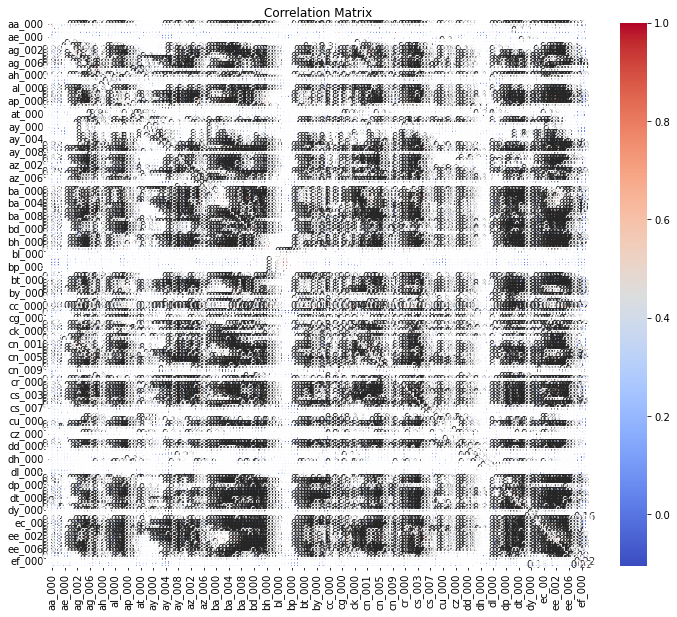

In [8]:
correlation_matrix = X_combined.corr()

plt.figure(figsize=(12, 10)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Matrix")
plt.show()

#### (iv) Make scatter plots and box plots

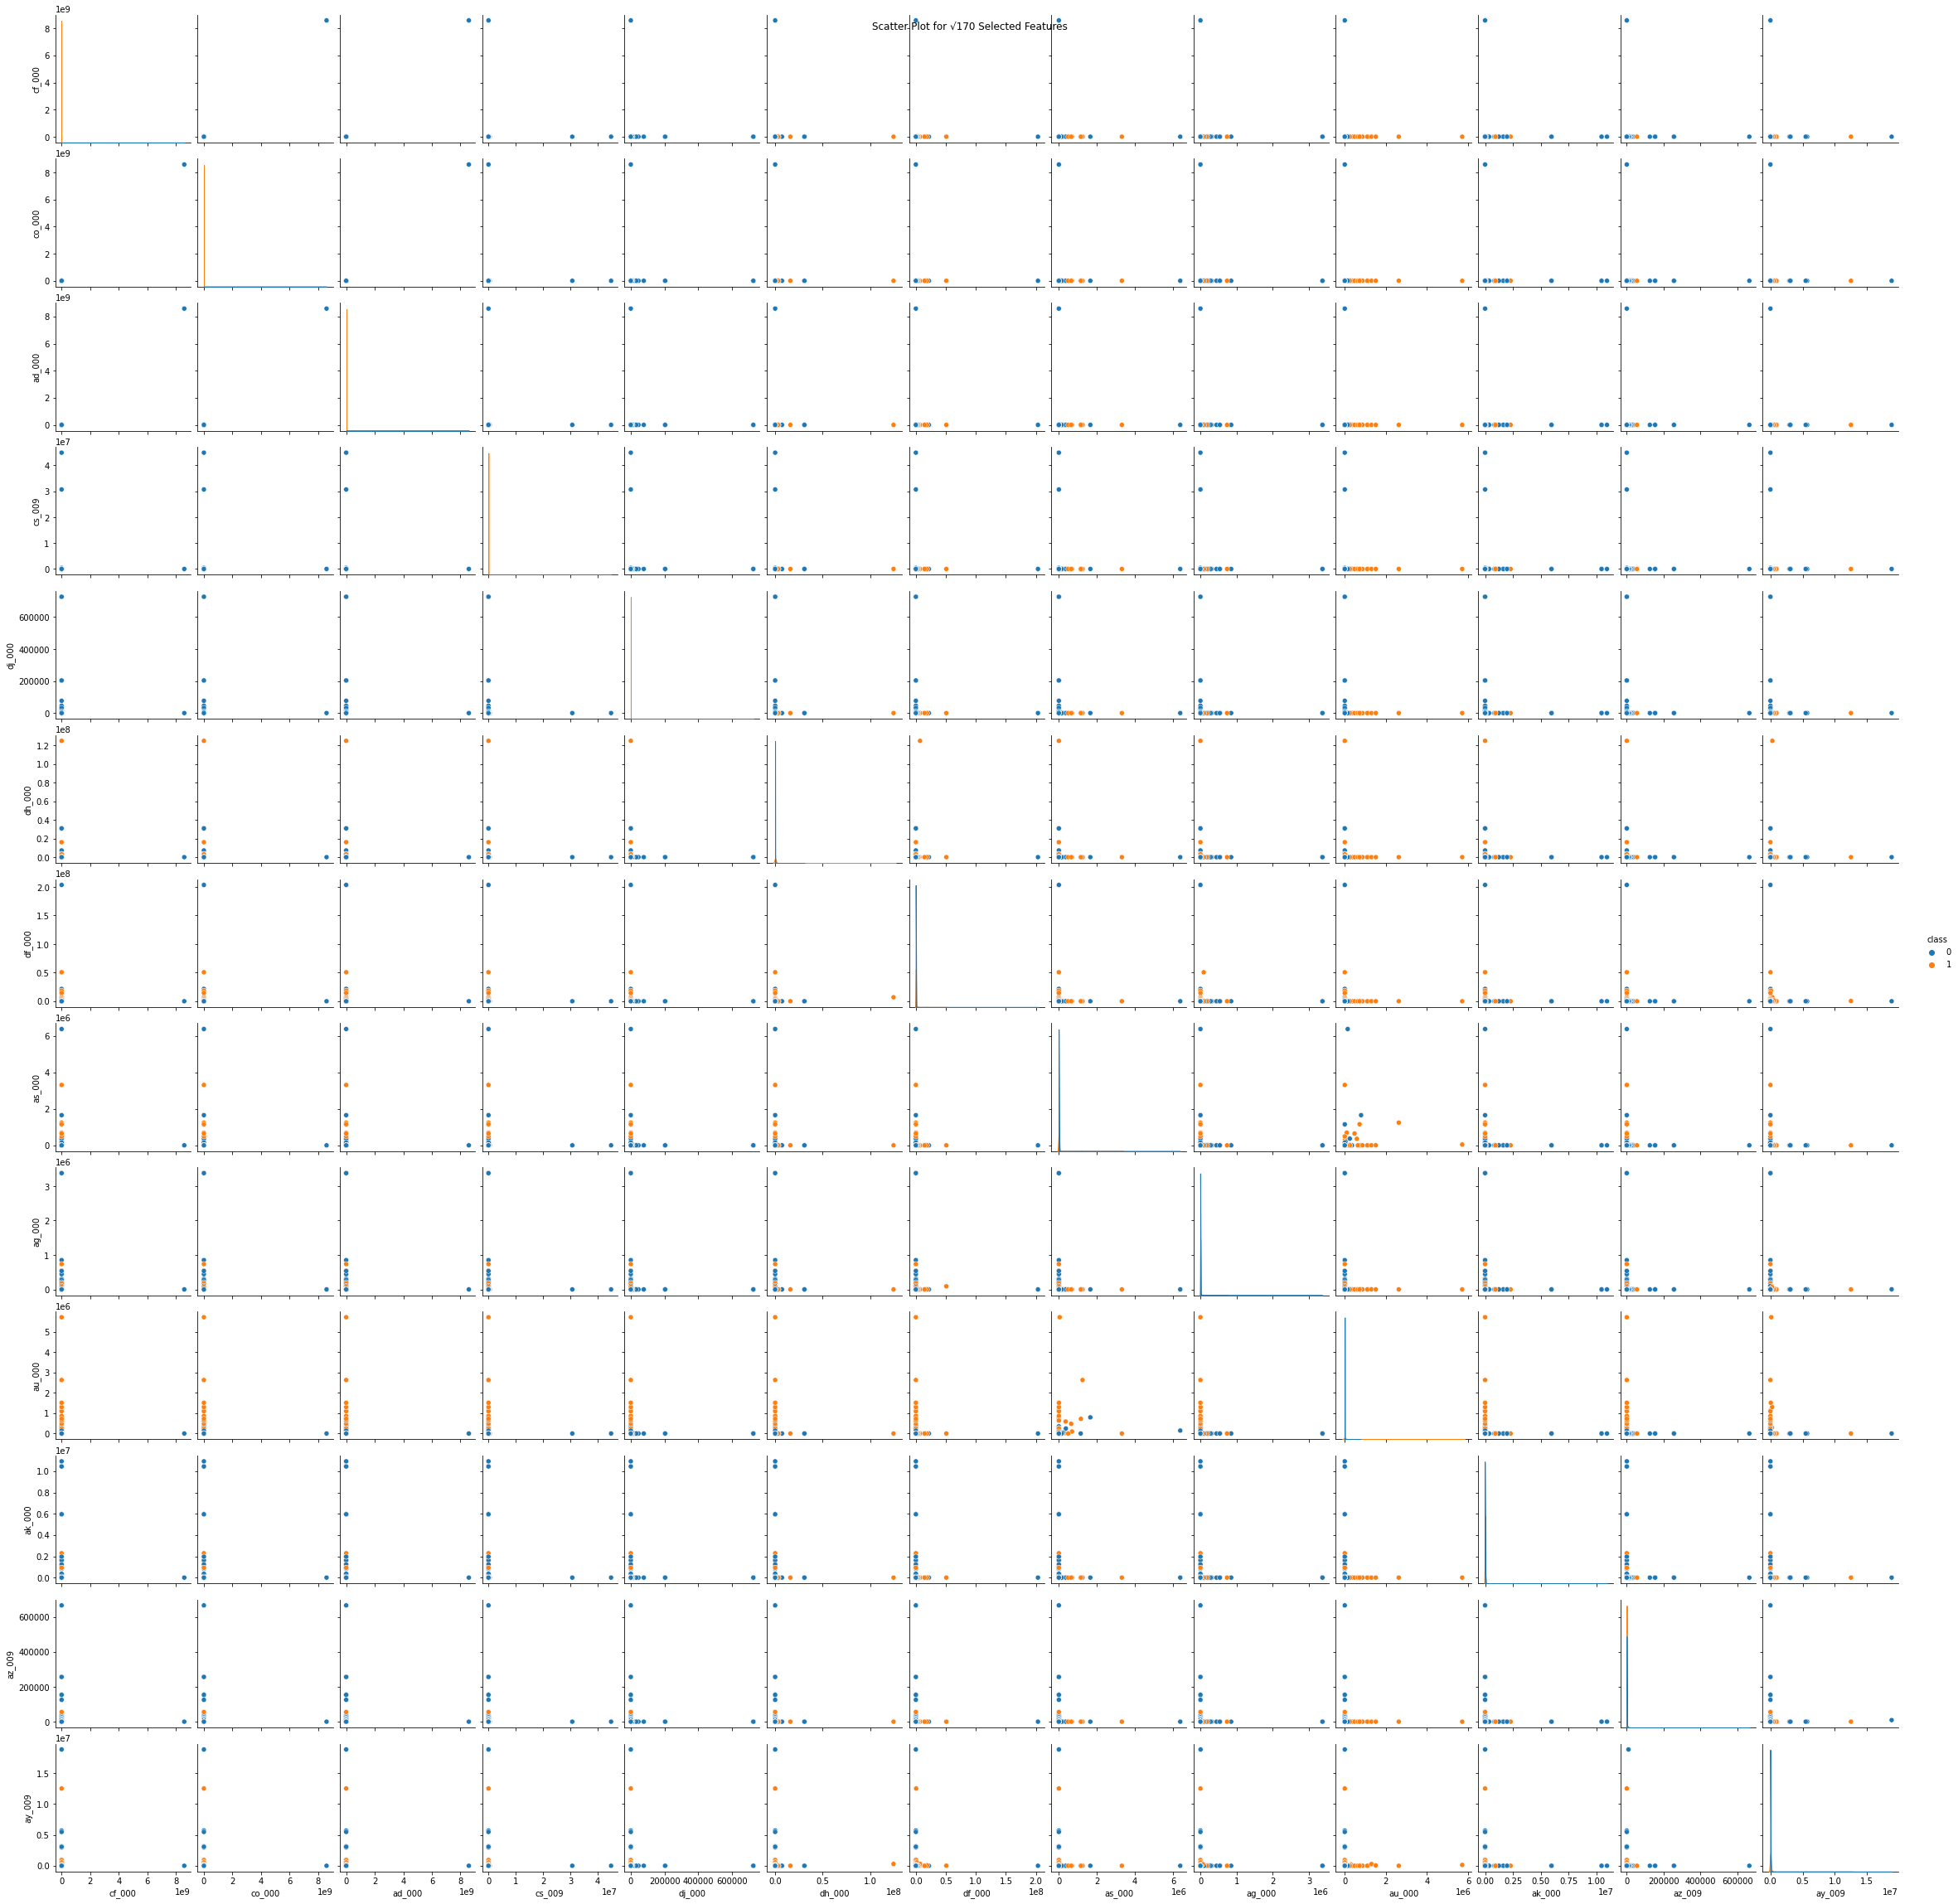

In [9]:
selected_features = list(cv_df_sorted['Feature'].head(int(np.sqrt(170))))
selected_features.append('class')
selected_data = combined_data[selected_features]

# scatter plot
sns.pairplot(selected_data, diag_kind="kde", hue='class')
plt.suptitle("Scatter Plot for √170 Selected Features")
plt.show()

No, I can't draw conclusions by the scatter plots about significance of those features. Probably bacause there are a lot of 0's.

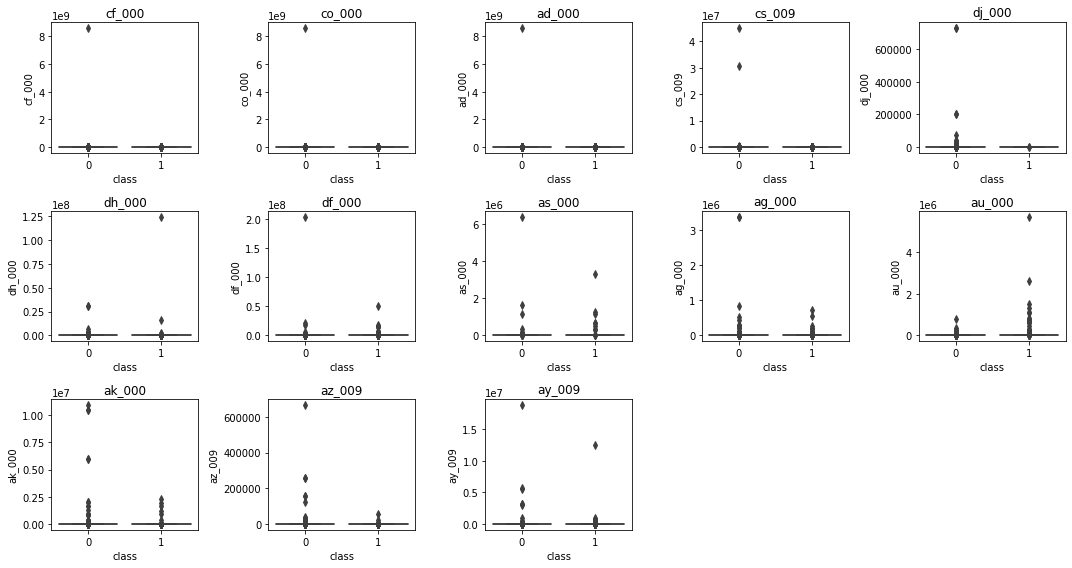

In [10]:
# box plot
selected_features = list(cv_df_sorted['Feature'].head(int(np.sqrt(170))))
features = list(selected_features)
num_features = len(features)
classes = [0, 1]

cols_per_row = 5
num_rows = (num_features + cols_per_row - 1) // cols_per_row
fig, axes = plt.subplots(nrows=num_rows, ncols=cols_per_row, figsize=(15, 8))
axes = axes.flatten()

# Hide any remaining empty subplots
for i in range(num_features, num_rows * cols_per_row):
    fig.delaxes(axes[i])

for i, feature in enumerate(features):
    axes[i] = sns.boxplot(x="class", y=feature, data=combined_data, ax=axes[i])
    axes[i].set_title(f"{feature}")

plt.tight_layout()
plt.show()

#### (v) Is this data set imbalanced?

In [11]:
print(combined_data['class'].value_counts(), end='\n')
print('\nNeg: ', round((combined_data['class'].value_counts()[0] / len(combined_data)) * 100, 3), '%', sep='')
print('Pos: ', round((combined_data['class'].value_counts()[1] / len(combined_data)) * 100, 3), '%', sep='')

class
0    74625
1     1375
Name: count, dtype: int64

Neg: 98.191%
Pos: 1.809%


Yes. The data set is severly imbalanced.

### (c) Train a random forest

Confusion Matrix (Training):
[[59000     0]
 [    1   999]]

Confusion Matrix (Test):
[[15610    15]
 [  106   269]]

AUC (Training): 1.00
AUC (Test): 0.86

Out of Bag Error Estimate: 0.01


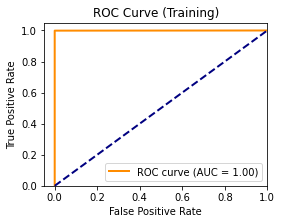

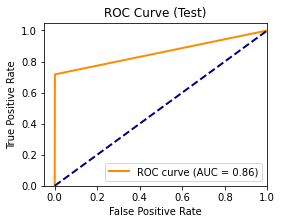

In [12]:
X_train = training.drop(columns=['class'])
X_test = test.drop(columns=['class'])
y_train = training[['class']]
y_test = test[['class']]

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rf_classifier.fit(X_train, y_train)

y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

oob_error = 1 - rf_classifier.oob_score_

print("Confusion Matrix (Training):")
print(confusion_matrix_train)
print("\nConfusion Matrix (Test):")
print(confusion_matrix_test)

print(f"\nAUC (Training): {roc_auc_train:.2f}")
print(f"AUC (Test): {roc_auc_test:.2f}")

print(f"\nOut of Bag Error Estimate: {oob_error:.2f}")

plt.figure(figsize=(4, 3))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_train:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training)')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend(loc="lower right")
plt.show()

### (d) Research class imbalance in random forest

#### Class Weight

Confusion Matrix (Training):
[[59000     0]
 [    1   999]]

Confusion Matrix (Test):
[[15610    15]
 [  135   240]]

AUC (Training): 1.00
AUC (Test): 0.82

Out of Bag Error Estimate: 0.01


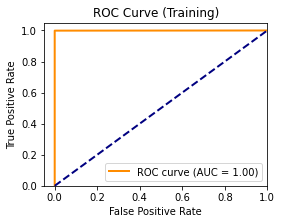

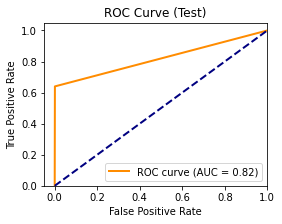

In [13]:
class_weights = {0: 1, 1: 10} 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights, oob_score=True)
rf_classifier.fit(X_train, y_train)

y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

oob_error = 1 - rf_classifier.oob_score_

print("Confusion Matrix (Training):")
print(confusion_matrix_train)

print("\nConfusion Matrix (Test):")
print(confusion_matrix_test)

print(f"\nAUC (Training): {roc_auc_train:.2f}")
print(f"AUC (Test): {roc_auc_test:.2f}")

print(f"\nOut of Bag Error Estimate: {oob_error:.2f}")

plt.figure(figsize=(4, 3))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_train:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training)')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend(loc="lower right")
plt.show()

Using class weight didn't really help improve the model.

### (e) XGBoost and Model Trees

Cross-validation score: 0.9907663135593221
Test score: 0.996199936

Confusion Matrix (Training):
[[58995     5]
 [   91   909]]

Confusion Matrix (Test):
[[15614    11]
 [   89   286]]

AUC (Training): 0.95
AUC (Test): 0.88


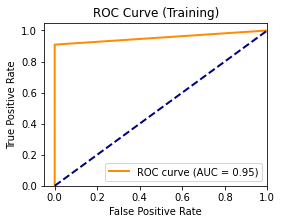

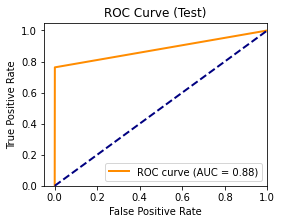

In [14]:
X_train = training.drop(columns=['class'])
X_test = test.drop(columns=['class'])
y_train = training['class']
y_test = test['class']

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'classifier__alpha': [0, 0.1, 0.5, 1, 10, 100],
    'classifier__n_estimators': [100, 200, 300], 
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5], 
}

pipeline = Pipeline(steps=[['scaler', MinMaxScaler()],
                           ['classifier', xgb.XGBClassifier(booster='gbtree',
                                                            tree_method='hist',
                                                            objective='binary:logistic',
                                                            use_label_encoder=False,
                                                            random_state=11)]])

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=stratified_kfold, n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print("\nConfusion Matrix (Training):")
print(confusion_matrix_train)
print("\nConfusion Matrix (Test):")
print(confusion_matrix_test)

print(f"\nAUC (Training): {roc_auc_train:.2f}")
print(f"AUC (Test): {roc_auc_test:.2f}")

plt.figure(figsize=(4, 3))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_train:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training)')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend(loc="lower right")
plt.show()

### (f) Use SMOTE to pre-process your data

In [15]:
X_train = training.drop(columns=['class'])
X_test = test.drop(columns=['class'])
y_train = training['class']
y_test = test['class']

pipeline = imbpipeline(steps=[['smote', SMOTE(random_state=42)],
                              ['scaler', MinMaxScaler()],
                              ['classifier', xgb.XGBClassifier(booster='gbtree',
                                                               tree_method='hist',
                                                               objective='binary:logistic',
                                                               use_label_encoder=False,
                                                               random_state=11)]])

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'classifier__alpha': [0, 0.1, 0.5, 1, 10, 100],
    'classifier__n_estimators': [100, 200, 300], 
    'classifier__learning_rate': [0.01, 0.1, 0.2], 
    'classifier__max_depth': [3, 4, 5], 
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=stratified_kfold, n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')

Cross-validation score: 0.9870068644067796
Test score: 0.9948211199999999


After performing SMOTE, the test score didn't improve.

## 2. ISLR 6.6.3

**a. Training RSS**<br>
Steadily decrease. When we increase s, we are reducing the restriction on β and making the model more and more flexible. Hence, training RSS will steadily decrease.

**b. TEST RSS**<br>
Decrease initially, and then eventually start increasing in a U shape. The test RSS will decrease at first because the model became more flexible, but after it started overfitting the training data, the test RSS will increase.

**c. variance**<br>
Steadily increase. Increasing s makes the model more flexible, and more flexible models have higher variances.

**d. (squared) bias**<br>
Steadily decrease. When the model becomes more flexible, bias will decrease.

**e. irreducible error**<br>
Remain constant. The irreducible error is independent of the model and will not be affected by s.

## 3. ISLR 6.6.5

#### a.
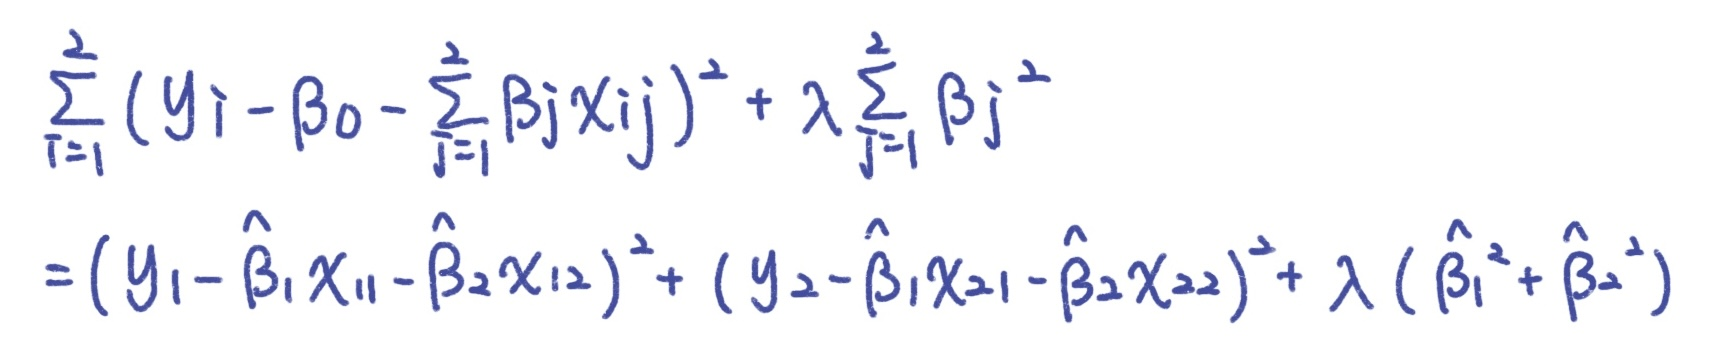

#### b. 
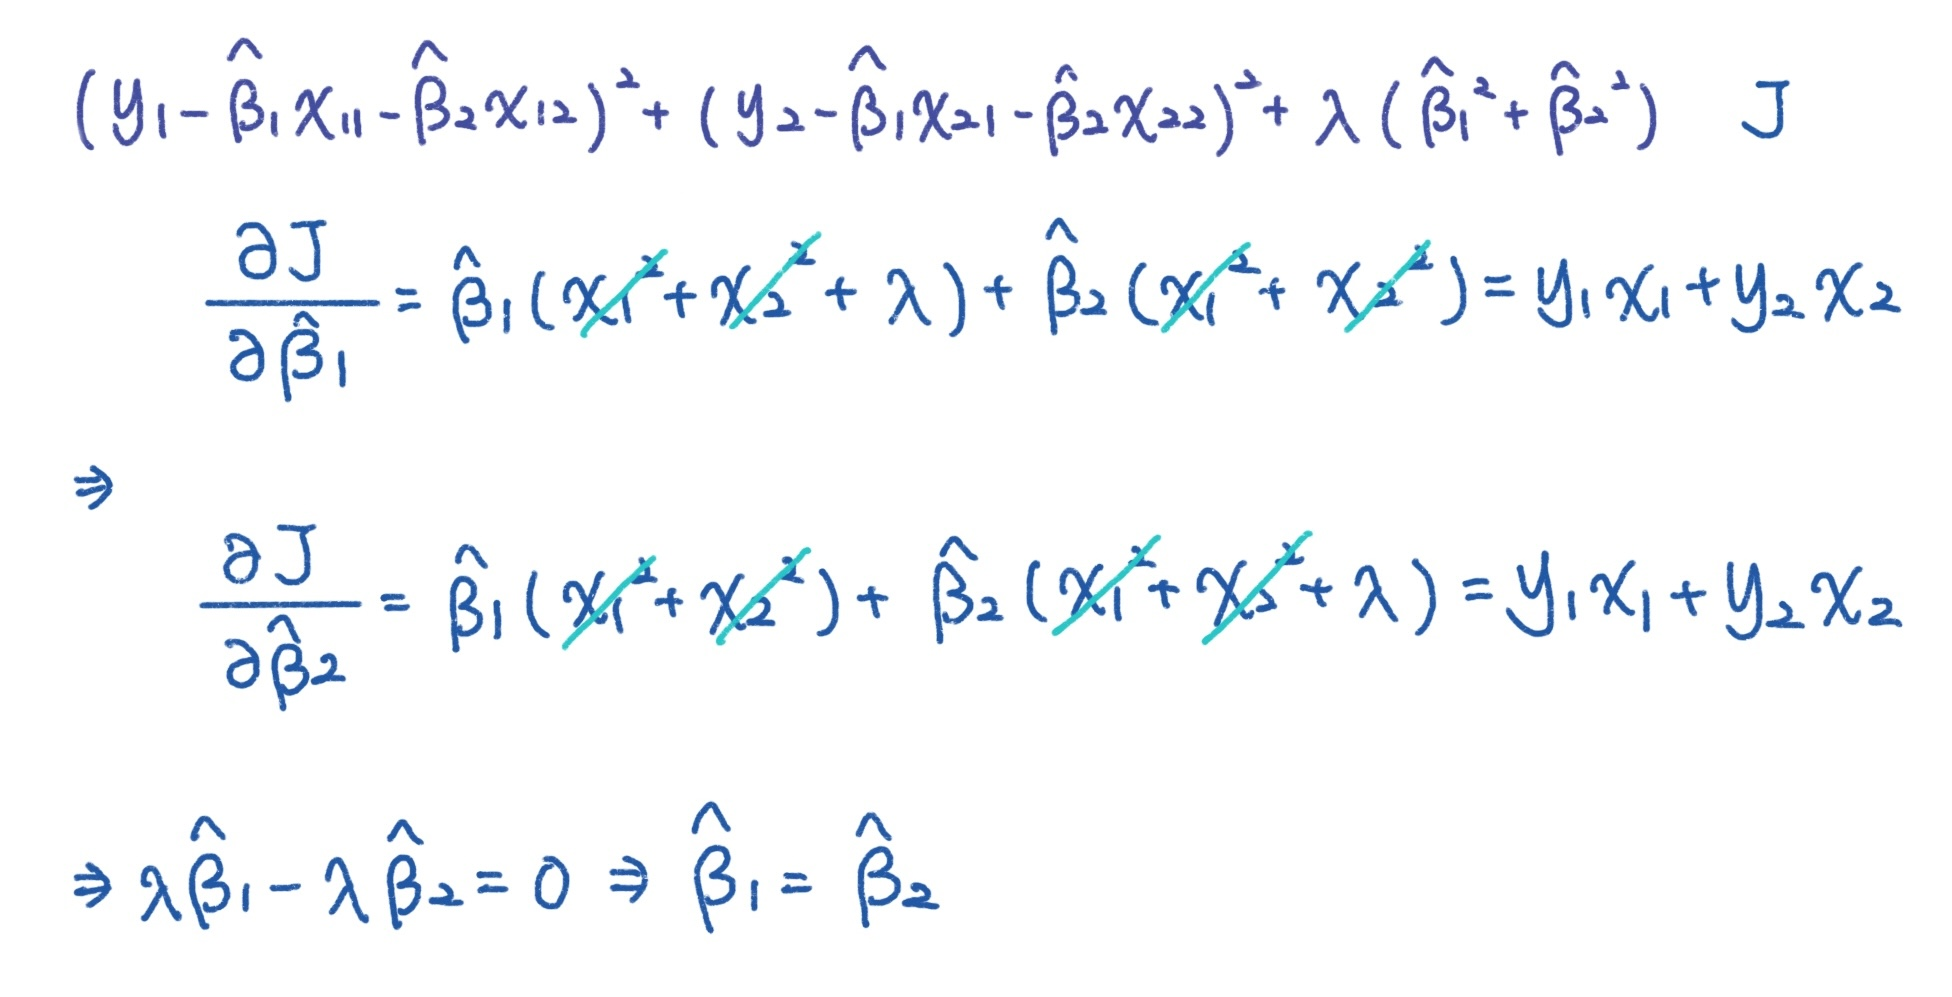

#### c.
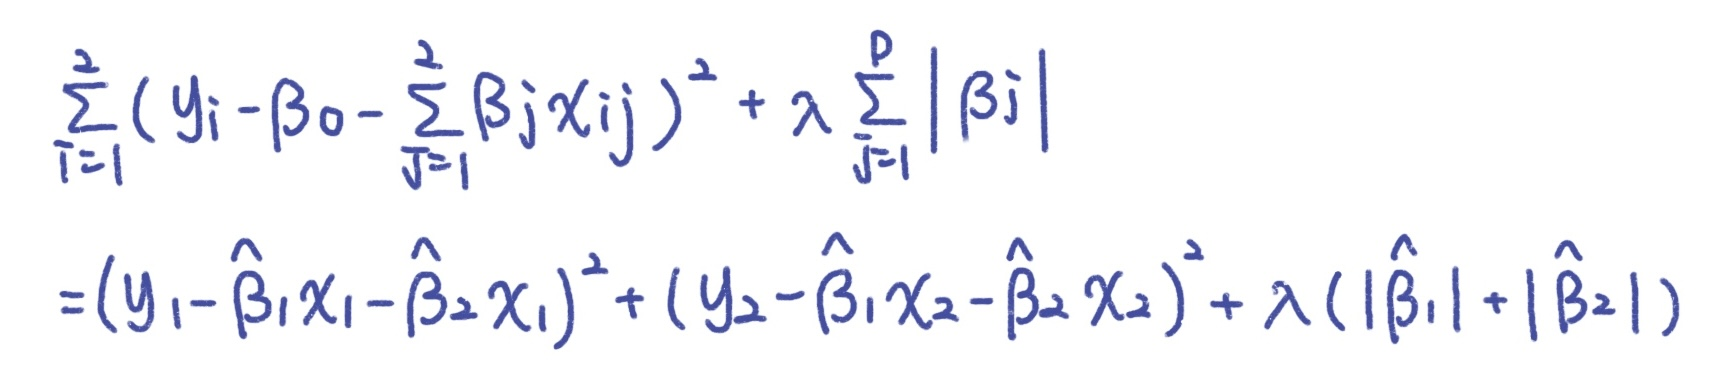

#### d.
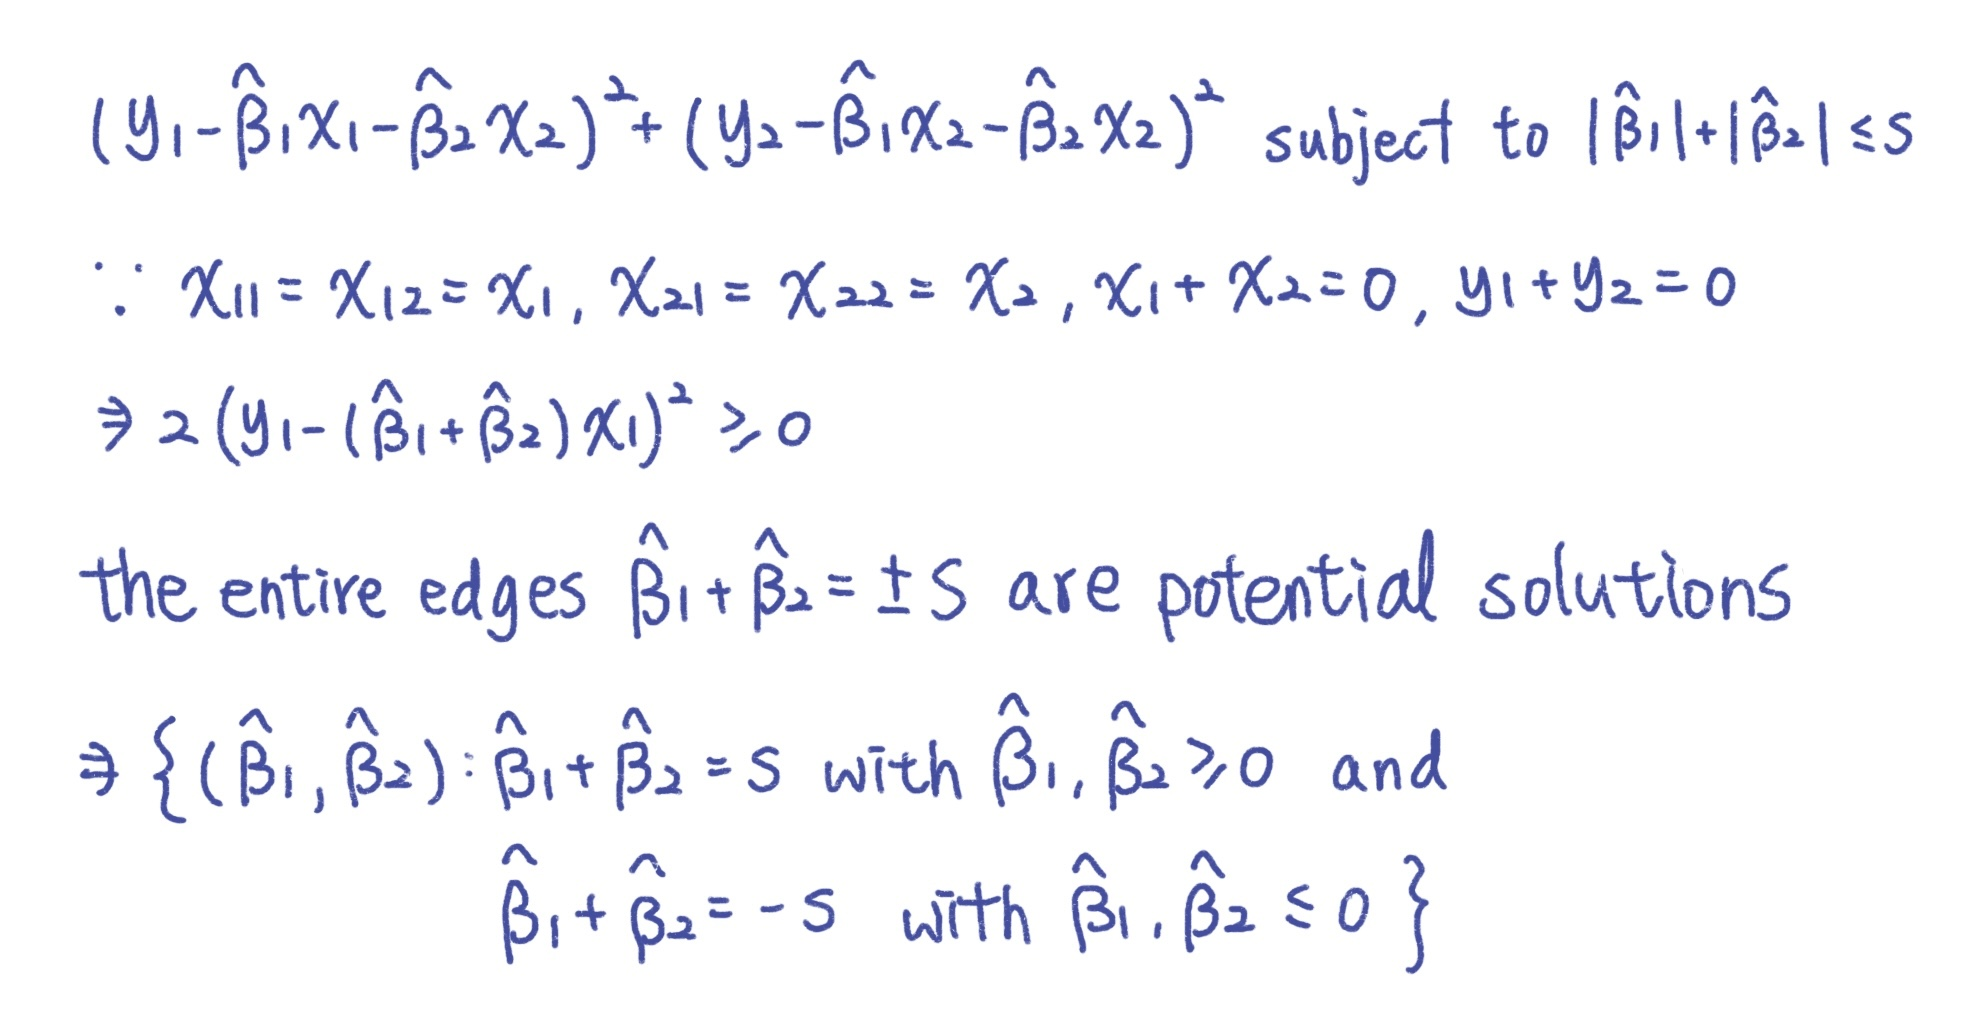

## 4. ISLR 8.4.5

In [16]:
probs = [0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75]

# majority vote
for i in probs:
    red, green = 0, 0
    if i < 0.5:
        green += 1
    elif i > 0.5:
        red += 1

if red > green:
    print('Majority Vote: Red')
elif green > red:
    print('Majority Vote: Green')

# average probability
average = sum(probs) / len(probs)

if average > 0.5:
    print('Average Probability: Red')
elif average < 0.5:
    print('Average Probability: Green')

Majority Vote: Red
Average Probability: Green


## 5. ISLR 9.7.3

#### a.

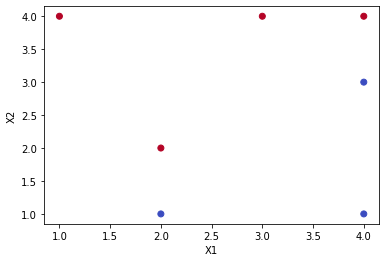

In [17]:
data = pd.DataFrame({'X1': [3, 2, 4, 1, 2, 4, 4],
                     'X2': [4, 2, 4, 4, 1, 3, 1],
                     'Y': ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']})

data['Y'] = data['Y'].apply(lambda x: 1 if x == 'red' else -1)

X = data[['X1', 'X2']]
y = data['Y']

plt.scatter(X['X1'], X['X2'], c=y, cmap='coolwarm')

ax = plt.gca()
xlim = ax.get_xlim()

plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

#### b.

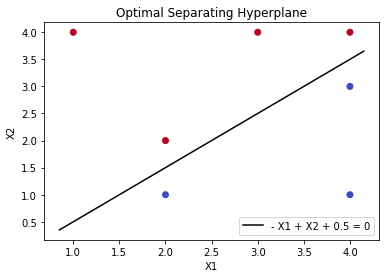

In [18]:
data = pd.DataFrame({'X1': [3, 2, 4, 1, 2, 4, 4],
                     'X2': [4, 2, 4, 4, 1, 3, 1],
                     'Y': ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']})

data['Y'] = data['Y'].apply(lambda x: 1 if x == 'red' else -1)

X = data[['X1', 'X2']]
y = data['Y']

plt.scatter(X['X1'], X['X2'], c=y, cmap='coolwarm')

ax = plt.gca()
xlim = ax.get_xlim()
xx = np.linspace(xlim[0], xlim[1])
yy = xx - 0.5
plt.plot(xx, yy, color='k', label='- X1 + X2 + 0.5 = 0')

plt.title("Optimal Separating Hyperplane")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

#### c.

Classify to Red if 0.5 - X1 + X2 > 0, and classify to Blue otherwise.<br>
β0 = 0.5, β1 = -1, β2 = 1

#### d. 

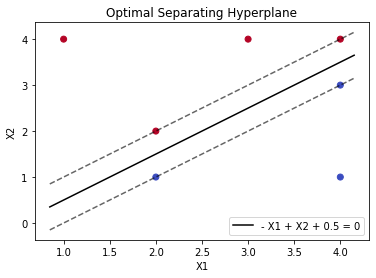

In [19]:
data = pd.DataFrame({'X1': [3, 2, 4, 1, 2, 4, 4],
                     'X2': [4, 2, 4, 4, 1, 3, 1],
                     'Y': ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']})

data['Y'] = data['Y'].apply(lambda x: 1 if x == 'red' else -1)

X = data[['X1', 'X2']]
y = data['Y']

plt.scatter(X['X1'], X['X2'], c=y, cmap='coolwarm')

ax = plt.gca()
xlim = ax.get_xlim()
xx = np.linspace(xlim[0], xlim[1])
yy = xx - 0.5
plt.plot(xx, yy, color='k', linestyle='-', label='- X1 + X2 + 0.5 = 0')

yy1 = xx
yy2 = xx - 1
plt.plot(xx, yy1, color='k', linestyle='--', alpha=0.6)
plt.plot(xx, yy2, color='k', linestyle='--', alpha=0.6)

plt.title("Optimal Separating Hyperplane")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

#### e.

In [20]:
pd.DataFrame({'X1': [2, 4, 2, 4],
              'X2': [2, 4, 1, 3],
              'Y': ['red', 'red', 'blue', 'blue']})

,X1,X2,Y
0,2,2,red
1,4,4,red
2,2,1,blue
3,4,3,blue


#### f.
Since the seventh observation is not a support vector, a slight movement won't affect the maximal margin hyperplane

#### g.

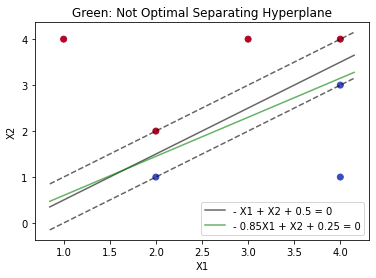

In [21]:
data = pd.DataFrame({'X1': [3, 2, 4, 1, 2, 4, 4],
                     'X2': [4, 2, 4, 4, 1, 3, 1],
                     'Y': ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']})

data['Y'] = data['Y'].apply(lambda x: 1 if x == 'red' else -1)

X = data[['X1', 'X2']]
y = data['Y']

plt.scatter(X['X1'], X['X2'], c=y, cmap='coolwarm')

ax = plt.gca()
xlim = ax.get_xlim()
xx = np.linspace(xlim[0], xlim[1])
yy = xx - 0.5
plt.plot(xx, yy, color='k', linestyle='-', label='- X1 + X2 + 0.5 = 0', alpha=0.6)

yy1 = xx
yy2 = xx - 1
yy3 = 0.85*xx - 0.25
plt.plot(xx, yy1, color='k', linestyle='--', alpha=0.6)
plt.plot(xx, yy2, color='k', linestyle='--', alpha=0.6)
plt.plot(xx, yy3, color='g', label='- 0.85X1 + X2 + 0.25 = 0', alpha=0.6)

plt.title("Green: Not Optimal Separating Hyperplane")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

#### h.

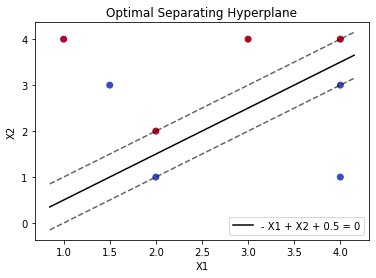

In [22]:
data = pd.DataFrame({'X1': [3, 2, 4, 1, 2, 4, 4, 1.5],
                     'X2': [4, 2, 4, 4, 1, 3, 1, 3],
                     'Y': ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue']})

data['Y'] = data['Y'].apply(lambda x: 1 if x == 'red' else -1)

X = data[['X1', 'X2']]
y = data['Y']

plt.scatter(X['X1'], X['X2'], c=y, cmap='coolwarm')

ax = plt.gca()
xlim = ax.get_xlim()
xx = np.linspace(xlim[0], xlim[1])
yy = xx - 0.5
plt.plot(xx, yy, color='k', linestyle='-', label='- X1 + X2 + 0.5 = 0')

yy1 = xx
yy2 = xx - 1
plt.plot(xx, yy1, color='k', linestyle='--', alpha=0.6)
plt.plot(xx, yy2, color='k', linestyle='--', alpha=0.6)

plt.title("Optimal Separating Hyperplane")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()